<a href="https://colab.research.google.com/github/yurybikuzin/skillfactory_rds6_ford_vs_ferrari/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time
!pip install fsspec gcsfs
!pip install -q -U tensorflow-addons

CPU times: user 20.5 ms, sys: 47 ms, total: 67.5 ms
Wall time: 5.4 s


In [ ]:
%%time
import sys
import numpy as np
import pandas as pd
import tensorflow as tf

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Pandas       : 1.1.2
Tensorflow   : 2.3.0
Keras        : 2.4.0
CPU times: user 466 µs, sys: 0 ns, total: 466 µs
Wall time: 352 µs


In [ ]:
import os
from google.colab import auth

auth.authenticate_user()    

try:
    tf.get_logger().propagate = False
    if 'COLAB_TPU_ADDR' in os.environ: #colab
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
    else: #kaggle
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    STRATEGY = tf.distribute.experimental.TPUStrategy(resolver)
    print('TPU initialized, num of accelerators:', STRATEGY.num_replicas_in_sync)
except (ValueError, KeyError):
    print('TPU not found, using CPU/GPU')
    STRATEGY = tf.distribute.get_strategy()

INFO:tensorflow:Initializing the TPU system: grpc://10.6.157.234:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

In [ ]:
%%time
# version 0.0.35
import shutil, pathlib, zipfile

TEST_TOTAL_COUNT = 6675
TRAIN_TOTAL_COUNT = 15561
VALID_SHARE = 0.25
INFIX = str(round(VALID_SHARE*100))
UNZIPPED_DIRNAMES = {'train': 'train', 'test': 'test_upload'}
GS_ROOT_DIR = 'gs://yurybikuzin/car-classification'
SHARD_SIZE = 1024 
CAT_NAMES = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

def get_data_name(of_kind, submission_name=None):
  if of_kind != 'test' or submission_name is None:
    data_name = of_kind
  else:
    data_name = f'{of_kind}-{submission_name}'
  return data_name

def get_gs_df_filename(of_kind, submission_name=None):
  data_name = get_data_name(of_kind, submission_name=submission_name)
  df_filename = f'{data_name}.csv'
  return df_filename

def get_gs_df_filepath(of_kind, submission_name=None):
  df_filename = get_gs_df_filename(of_kind, submission_name=submission_name)
  return f'{GS_ROOT_DIR}/prepared/{df_filename}'

def unzip_data(of_kind, force=False):
  print(f"unzip_data {of_kind} . . .")
  dirname = UNZIPPED_DIRNAMES[of_kind]
  from_path = f'unzipped/{dirname}'
  if force or not os.path.isdir(from_path):
    shutil.rmtree(from_path, ignore_errors = True)
    dst = f'data/{of_kind}.zip'
    if force or not os.path.isfile(dst):
      if os.path.exists(dst):
        os.remove(dst)
        print(f'Removed {dst}')
      src = f'{GS_ROOT_DIR}/data/{of_kind}.zip'
      pathlib.Path(os.path.dirname(dst)).mkdir(parents = True, exist_ok = True)
      print(f"Copy {src} to {dst} . . .")
      tf.io.gfile.copy(src, dst)
    print(f"Unzip {dst} . . .")
    with zipfile.ZipFile(dst,"r") as z:
      z.extractall('unzipped')
    print("unzipped")
  return from_path

@tf.autograph.experimental.do_not_convert
def prepare_df(from_path, of_kind, submission_name=None):
  print(f"prepare_df {get_data_name(of_kind, submission_name)} . . .")
  categorys = []
  filepaths = []
  if of_kind == 'train':
    for (dirpath, dirnames, filenames) in os.walk(from_path):
      if len(filenames) > 0:
        filepaths.extend( map(lambda filename: os.path.join(dirpath, filename), filenames) )
        category = int(os.path.basename(dirpath))
        categorys.extend( [category] * len(filenames) )
  elif submission_name is None:
    sample_submission = pd.read_csv(f'{GS_ROOT_DIR}/data/sample-submission.csv')
    filepaths = list(map(lambda filename: f'{from_path}/{filename}', sample_submission['Id'].tolist()))
    categorys = [0] * len(filepaths)
  else:
    submission = pd.read_csv(f'{GS_ROOT_DIR}/submissions/subm-{submission_name}.csv')
    filepaths = list(map(lambda filename: f'{from_path}/{filename}', submission['Id'].tolist()))
    categorys = submission['Category'].tolist()
  data = {'filepath': filepaths, 'cat': categorys}
  df = pd.DataFrame(data=data)
  if of_kind == 'train':
    df = df.sample(frac=1).reset_index(drop=True)
  print("prepare_df is done", df.head(20))
  return df

def write_tfrec(out_dirpath, batch_index, images, cats, data_name, images_processed):
  out_filename = f'{batch_index}.tfrec'
  dst = f'{GS_ROOT_DIR}/prepared/{data_name}/{out_filename}'
  out_filepath = out_dirpath + '/' + out_filename
  images_ndarray = images.numpy() #tf.io.read_file возвращает байты, поэтому images - набор байт, т. е. тензор типа tf.string
  cats_ndarray = cats.numpy()
  examples_count = images_ndarray.shape[0] #сколько изображений получено? (в последнем массиве их будет меньше SHARD_SIZE)

  if tf.io.gfile.exists(dst):
    tf.io.gfile.remove(dst)
  print('Writing file: %s [images %d-%d]' % (out_filepath, images_processed, images_processed + examples_count))
  
  with tf.io.TFRecordWriter(out_filepath) as out_file:
    for i in range(examples_count):
      feature = {
          'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [images_ndarray[i]])),
          'cat': tf.train.Feature(int64_list = tf.train.Int64List(value = [cats_ndarray[i]])),
      }
      tfrecord = tf.train.Example(features = tf.train.Features(feature = feature))
      out_file.write(tfrecord.SerializeToString())
  print(f"Copy {out_filepath} {dst} . . .")
  tf.io.gfile.copy(out_filepath, dst)

  images_processed += examples_count
  return images_processed

@tf.autograph.experimental.do_not_convert
def prepare_data(of_kind, force=False, submission_name=None):
  data_name = get_data_name(of_kind, submission_name=submission_name)
  df_filename = get_gs_df_filename(of_kind, submission_name=submission_name)
  gs_df_filepath = get_gs_df_filepath(of_kind, submission_name=submission_name)
  if force or not tf.io.gfile.exists(gs_df_filepath):
    print(f'Prepare data {data_name} . . .')
    if tf.io.gfile.exists(gs_df_filepath):
      tf.io.gfile.remove(gs_df_filepath)
    df_filepath = f'prepared/{df_filename}'
    if force or not os.path.isdir(df_filepath):
      
      if os.path.exists(df_filepath):
        os.remove(df_filepath)
      out_dirpath = f'prepared/{data_name}'
      shutil.rmtree(out_dirpath, ignore_errors = True)
      from_path = unzip_data(of_kind, force=force)

      df = prepare_df(from_path, of_kind, submission_name=submission_name)

      with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
        filepaths = df['filepath']
        cats = df['cat'].astype('int64')
        dataset = tf.data.Dataset.from_tensor_slices((filepaths, cats))
        dataset = dataset.map(
            lambda filepath, attr: (tf.io.read_file(filepath), attr)
        ).batch(SHARD_SIZE)

        shutil.rmtree(out_dirpath, ignore_errors = True) #удаляем папку со старыми файлами
        pathlib.Path(out_dirpath).mkdir(parents = True, exist_ok = True)
        print(f'Removed {out_dirpath}')

        images_processed = 0
        for batch_index, (images, cats) in enumerate(dataset):
          write_tfrec(out_dirpath, batch_index, images, cats, data_name, images_processed)

      df['filename'] = df['filepath'].apply(lambda filepath: os.path.basename(filepath))
      df.drop('filepath', axis="columns", inplace=True) 
      df.to_csv(df_filepath, index=False)
      dst = gs_df_filepath
      print(f"Copy {df_filepath} {dst} . . .")
      tf.io.gfile.copy(df_filepath, dst)
      print('Copied')
  print(f'Prepared data {data_name}')
  return f'{GS_ROOT_DIR}/prepared/{data_name}'
    
# ==============================================================================

import re

def get_size_from_model_name(model_name):
  size_search = re.search('(\d+)x(\d+)', model_name)
  if size_search:
      return int(size_search.group(2)), int(size_search.group(1))
  else:
    raise Exception(f'could not obtain size from model name {model_name}')

@tf.autograph.experimental.do_not_convert
def prepare_submission_of(model_name, batch_size=32):
  filepath = get_submission_filepath(model_name)
  if tf.io.gfile.exists(filepath):
    print(f"{filepath} already exists")
  else:
    labels = get_test_predictions_of(model_name, batch_size)

    df_test = pd.read_csv(get_gs_df_filepath('test'))
    filenames = df_test['filename'].to_list()
    filenames = list(map(lambda i: get_filename_by_i(i, filenames), range(0, len(filenames))))
    df = pd.DataFrame(data={'Id': filenames, 'Category': labels})
    df.to_csv(filepath, index=False)
    print(f"Saved {filepath}")

def load_submission_from_gs(filename):
  dst = filename
  src = f'{GS_ROOT_DIR}/submissions/{dst}'
  if os.path.exists(dst):
    os.remove(dst)
  print(f'Loading {src} . . .')
  tf.io.gfile.copy(src, dst)
  df = pd.read_csv(dst)
  print(f'Loaded {src}')
  return df

def get_test_predictions_of(model_name, batch_size=32):
  if model_name not in _predicts:
    size = get_size_from_model_name(model_name)
    raw_test_dataset = get_raw_test_dataset()
    val_dataset = get_val_dataset(raw_test_dataset, size=size)
    print("Run model . . .")
    model = get_ready_model(model_name)
    predictions = model.predict(val_dataset.batch(batch_size))
    print("Got predictions")
    _predicts[model_name] = np.argmax(predictions, axis = 1)
  return _predicts[model_name]

def get_cat_acc(model_name, batch_size=32):
  if model_name not in _cat_accs:
    correct, predict = get_model_artefacts(model_name, batch_size=batch_size)
    predict_counts = [0] * 10
    true_counts = [0] * 10
    for i in range(len(correct)):
      predict_counts[predict[i]] += 1
      if correct[i] == predict[i]:
        true_counts[predict[i]] += 1
    result = [0] * 10
    for i in range(10):
      result[i] = true_counts[i] / predict_counts[i]
    _cat_accs[model_name] = result
  return _cat_accs[model_name]

DEFAULT_MODE = 'max'
DEFAULT_BATCH_SIZE = 32

def get_composite_predict(model_names, predicts, mode=DEFAULT_MODE, batch_size=DEFAULT_BATCH_SIZE):
  composite_predict = []
  if len(model_names) > 0:
    cat_accs = {}
    for model_name in model_names:
      cat_accs[model_name] = get_cat_acc(model_name, batch_size=batch_size) 
      print(f'cat_accs[{model_name}:', cat_accs[model_name])
    print(f'mode {mode}')
    for i in range(len(predicts[model_names[0]])):
      votes = [0] * 10
      for model_name in model_names:
        predict = predicts[model_name]
        if mode == 'sum':
          votes[predict[i]] += cat_accs[model_name][predict[i]]
        elif mode == 'max':
          votes[predict[i]] = max(votes[predict[i]], cat_accs[model_name][predict[i]])
        else:
          raise Exception(f'unexpected mode {mode}')
      composite_predict.append(np.argmax(np.asarray(votes)))
  return composite_predict

@tf.autograph.experimental.do_not_convert
def get_composite_submission(model_names, mode=DEFAULT_MODE, batch_size=DEFAULT_BATCH_SIZE):
  print("Get raw_test_dataset . . .")
  raw_test_dataset = get_raw_test_dataset()
  predicts = {}
  for model_name in model_names:
    predicts[model_name] = get_test_predictions_of(model_name, batch_size)

  df_test = pd.read_csv(get_gs_df_filepath('test'))
  filenames = df_test['filename'].to_list()
  composite_predict = get_composite_predict(model_names, predicts, mode=mode, batch_size=batch_size)
 
  filenames = list(map(lambda i: get_filename_by_i(i, filenames), range(0, len(filenames))))
  print(f'filenames: {len(filenames)}, composite_predict: {len(composite_predict)}')
  data={'Id': filenames, 'Category': composite_predict}
  for model_name in model_names:
    data[model_name] = _predicts[model_name]
  return pd.DataFrame(data)

@tf.autograph.experimental.do_not_convert
def show_confusion_matrix_of_composite(model_names, mode=DEFAULT_MODE, batch_size=DEFAULT_BATCH_SIZE):
  predicts = {}
  correct_answers = []
  for model_name in model_names:
    correct_answers, predict = get_model_artefacts(model_name, batch_size)
    predicts[model_name] = predict

  composite_predict = get_composite_predict(model_names, predicts, mode=mode, batch_size=batch_size)

  correct_answers_count = np.bincount(correct_answers)
  confusion_matrix = np.zeros((10, 10))

  true_predicted_count = 0
  for i, correct_answer in enumerate(correct_answers):
    confusion_matrix[composite_predict[i], correct_answer] += 1
    if composite_predict[i] == correct_answer:
      true_predicted_count += 1

  import matplotlib.pyplot as plt
  fig = plt.figure(figsize = (16, 8))
  ax = fig.add_subplot(1, 2, 1)
  title = f'Composite confusion matrix ({mode})'
  ax.set_title(title, fontsize=24, pad=30)
  ax.imshow(confusion_matrix, cmap = 'gray', vmin = 0, vmax = 100)
  for i in range(10):
    for j in range(10):
      ax.text(j, i, str(int(confusion_matrix[i][j])), horizontalalignment = 'center',
              verticalalignment = 'center', color = 'black' if confusion_matrix[i][j] > 50 else 'white')
  ax.set_ylabel('prediction')
  ax.set_xlabel('correct answer')
  plt.show()
  print('Аccuracy: %.2f%%' % (true_predicted_count / sum(correct_answers_count) * 100))

def show_confusion_matrixs(model_names):
  for model_name in model_names:
    show_confusion_matrix(model_name)
  for mode in ['max', 'sum']:
    show_confusion_matrix_of_composite(model_names, mode=mode)

def get_submission_filepath(name):
  return f'{GS_ROOT_DIR}/submissions/subm-{name}.csv'

def save_submission(df, name):
  filepath = get_submission_filepath(name)
  df.to_csv(filepath, index=False)
  print(f"Saved {filepath}")


# ==============================================================================

import matplotlib.pyplot as plt

def visualize_dataset(pairs, title="Dataset", cols=3): #pair = (image, title)
    images_count = len(pairs)
    rows = -(-images_count // cols)
    fig = plt.figure(figsize = (5 * cols, 3 * rows))
    plt.title(label=title, fontsize=24, pad=30)
    plt.axis('off')
    for img_index in range(images_count):
        ax = fig.add_subplot(rows, cols, img_index + 1)
        img, title = pairs[img_index]
        if tf.is_tensor(img): img = img.numpy()
        if tf.is_tensor(title): title = title.numpy()
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

def read_train_tfrecord(serialized_example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'cat': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, features = features)
    return tf.image.decode_jpeg(example['image'], channels = 3), example['cat']

@tf.autograph.experimental.do_not_convert
def get_raw_dataset(from_path):
  with STRATEGY.scope():
      filepaths = []
      for (dirpath, dirnames, filenames) in tf.io.gfile.walk(from_path):
          if len(filenames) > 0:
              filepaths.extend( map(lambda filename: os.path.join(dirpath, filename), filenames) )
      def read_tfrecord(serialized_example):
          features = {
              'image': tf.io.FixedLenFeature([], tf.string),
              'cat': tf.io.FixedLenFeature([], tf.int64),
          }
          example = tf.io.parse_single_example(serialized_example, features = features)
          return tf.image.decode_jpeg(example['image'], channels = 3), example['cat']
      return tf.data.TFRecordDataset(
          filepaths,
          num_parallel_reads = len(filepaths)
      ).map(read_tfrecord) 

def prepare_raw_test_dataset_labeled_by_sumbission(model_name):
  prepare_submission_of(model_name)
  from_path = prepare_data(
      'test',  
      submission_name=model_name,
      # force=True,
      )
  global _raw_test_dataset_labeled
  _raw_test_dataset_labeled = get_raw_dataset(from_path)

def plot_examples(raw_dataset, get_label, take=9, skip=0, cols=3, title="Dataset", cast=None):
    pairs = list(raw_dataset.skip(skip).take(take))
    visualize_dataset(
        [ (img if cast is None else cast(img), get_label(attr, i)) for i, (img, attr) in enumerate(pairs) ], 
        title=title,
        cols=cols,
        )
  
def pad(image, size):
  image = tf.image.resize(image, size, preserve_aspect_ratio = True)
  return tf.image.resize_with_pad(image, *size)

def get_filename_by_i(i, filenames, skip=0):
  total_count = len(filenames)
  shard_count = -(-total_count//SHARD_SIZE)
  max_full_level = total_count % SHARD_SIZE
  threshold = max_full_level * shard_count
  n = i + skip
  if n <= threshold:
    idx = n//shard_count + n%shard_count*SHARD_SIZE
  else:
    n = n - threshold
    idx = max_full_level + n//(shard_count - 1) + n%(shard_count - 1) * SHARD_SIZE
  return filenames[idx]

# ==============================================================================

def save_model(model, name):
    src = f'{name}.h5'
    print(f"Save {src} . . .")
    if os.path.exists(src):
      os.remove(src)
    model.save(src)
    
    dst = f'{GS_ROOT_DIR}/models/{src}'
    print(f"Copy {src} to {dst} . . .")
    if tf.io.gfile.exists(dst):
      tf.io.gfile.remove(dst)
    tf.io.gfile.copy(src, dst)
  
def load_model(name):
  dst = f'{name}.h5'
  src = f'{GS_ROOT_DIR}/models/{dst}'
  if os.path.exists(dst):
    os.remove(dst)
  print(f'Loading {src} . . .')
  tf.io.gfile.copy(src, dst)
  model = tf.keras.models.load_model(dst)
  print(f'Loaded {src}')
  return model

def get_ready_model(key):
  if key not in _models:
    _models[key] = load_model(key)
  return _models[key]

# ============================================================================

@tf.autograph.experimental.do_not_convert
def get_model_artefacts(model_name, batch_size=64):
  if model_name not in _model_artefacts:
    size = get_size_from_model_name(model_name)
    val_count = int(get_train_count() * VALID_SHARE)
    raw_dataset = get_raw_train_dataset(addon=False).take(val_count)
    val_dataset = get_val_dataset(raw_dataset, size=size)
    print("Run model . . .")
    model = get_ready_model(model_name)
    predictions = model.predict(val_dataset.batch(batch_size))
    labels = np.argmax(predictions, axis = 1)
    print("Got predictions")

    correct_answers = [x[1] for x in val_dataset]

    _model_artefacts[model_name] = (correct_answers, labels)
  return _model_artefacts[model_name]

def get_model_errors(model_name, batch_size=64):
  correct_answers, labels = get_model_artefacts(model_name, batch_size)
  errors = []
  for i in range(0, len(correct_answers)):
    correct = correct_answers[i]
    predict =  labels[i]
    if correct != predict:
      errors.append((i, predict))
  return errors
   
@tf.autograph.experimental.do_not_convert
def show_confusion_matrix(model_name, batch_size=64):
  correct_answers, labels = get_model_artefacts(model_name, batch_size=batch_size)

  correct_answers_count = np.bincount(correct_answers)
  confusion_matrix = np.zeros((10, 10))

  true_predicted_count = 0
  for i, correct_answer in enumerate(correct_answers):
    confusion_matrix[labels[i], correct_answer] += 1
    if labels[i] == correct_answer:
      true_predicted_count += 1

  import matplotlib.pyplot as plt
  fig = plt.figure(figsize = (16, 8))
  ax = fig.add_subplot(1, 2, 1)
  title = model_name + ' confusion matrix'
  ax.set_title(title, fontsize=24, pad=30)
  ax.imshow(confusion_matrix, cmap = 'gray', vmin = 0, vmax = 100)
  for i in range(10):
    for j in range(10):
      ax.text(j, i, str(int(confusion_matrix[i][j])), horizontalalignment = 'center',
              verticalalignment = 'center', color = 'black' if confusion_matrix[i][j] > 50 else 'white')
  ax.set_ylabel('prediction')
  ax.set_xlabel('correct answer')
  plt.show()
  print('Аccuracy: %.2f%%' % (true_predicted_count / sum(correct_answers_count) * 100))


  
def visualize_errors(errors, title='errors', cols=3):
  triples = []
  raw_train_dataset = get_raw_train_dataset()
  for i, predict in errors:
    img, correct = list(raw_train_dataset.skip(i).take(1))[0]
    triples.append((img, correct, predict))
  images_count = len(triples)
  rows = - (-images_count // cols)
  fig = plt.figure(figsize = (cols * 5, rows * 3))
  plt.title(label=title, fontsize=24, pad=30)
  plt.axis('off')
  for img_index in range(images_count):
      ax = fig.add_subplot(rows, cols, img_index + 1)
      img, correct, predict = triples[img_index]
      if tf.is_tensor(img): img = img.numpy()
      if tf.is_tensor(correct): correct = correct.numpy()
      ax.imshow(img)
      correct_label = CAT_NAMES[correct]
      predict_label = CAT_NAMES[predict]
      title = f'c: {correct_label}, p: {predict_label}'
      ax.set_title(title)
      ax.axis('off')
  plt.show()

# ==============================================================================

def get_raw_train_dataset(addon=True):
  global _raw_train_dataset
  if _raw_train_dataset is None:
    from_path = f'{GS_ROOT_DIR}/prepared/train'
    _raw_train_dataset = get_raw_dataset(from_path)
  if _raw_test_dataset_labeled is None or not addon:
    return _raw_train_dataset
  else:
    print("get_raw_train_dataset: _raw_train_dataset.concatenate(_raw_test_dataset_labeled)")
    return _raw_train_dataset.concatenate(_raw_test_dataset_labeled)

def get_raw_test_dataset():
  global _raw_test_dataset
  if _raw_test_dataset is None:
    from_path = f'{GS_ROOT_DIR}/prepared/test'
    _raw_test_dataset = get_raw_dataset(from_path)
  return _raw_test_dataset

# ==============================================================================

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import time, gc

def get_train_count():
  if _raw_test_dataset_labeled is None:
    return TRAIN_TOTAL_COUNT
  else:
    return TRAIN_TOTAL_COUNT + TEST_TOTAL_COUNT

def get_val_dataset(raw_dataset, size):
  resizing_func_tuple = lambda img, label: (pad(img, size=size), label)
  preprocess_func_val = lambda img: tf.cast(img, tf.float32) / 128 - 1
  preprocess_func_tuple_val = lambda img, label: (preprocess_func_val(img), label)
  val_dataset = raw_dataset.map(resizing_func_tuple).map(preprocess_func_tuple_val)
  return val_dataset

def get_model(
    target_size, 
    dense_layer=None, 
    layers=None, 
    optimizer=None, 
    loss=None, 
    metrics=None, 
    force_new_model=False, 
    base_model_class=None, 
    model_src_name=None,
    fine_tune_layers_percentage=None):
    if force_new_model and model_src_name is not None:
      raise Exception(f'can not create new model and load {model_src_name} at same time')
    global _model
    if _model is not None and not force_new_model and fine_tune_layers_percentage is None and model_src_name is None:
        return _model 
    if model_src_name is not None:
      _model = get_ready_model(model_src_name)   
    elif force_new_model or _model is None:
      print(f'force_new_model: {force_new_model}, _model is None: {_model is None}')
      if base_model_class is None:
        base_model_class = tf.keras.applications.xception.Xception
      print("base_model_class:", base_model_class)
      _model = tf.keras.Sequential()
      _model.add(base_model_class(
        weights = 'imagenet',
        include_top = False,
        input_shape = (target_size[0], target_size[1], 3)
        ))
      if layers is None:
        import tensorflow.keras.layers as L
        layers = [
            L.GlobalMaxPooling2D(),
            L.BatchNormalization(),
            L.Dropout(0.3),
            L.Dense(256 if dense_layer is None else dense_layer, activation = 'relu'),
            L.BatchNormalization(),
            L.Dense(10),
        ]
      for layer in layers:
        _model.add(layer)
    if fine_tune_layers_percentage is not None:
      base_model = _model.layers[0]
      if fine_tune_layers_percentage == 0:
        base_model.trainable = False
      else:
        base_model.trainable = True
        non_trainable_count = len(base_model.layers) * abs(100 - fine_tune_layers_percentage) // 100
        for layer in base_model.layers[0:non_trainable_count]:
          layer.trainable = False
        for layer in base_model.layers[non_trainable_count:]:
          layer.trainable = True
      print(f"Finetune model: {fine_tune_layers_percentage}% trainable")
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(
            learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                0.0008, decay_steps = 100, decay_rate = 0.9)
            )
    if loss is None:
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    if metrics is None:
        metrics=['accuracy']
    # print("model build . . .")
    # _model.build()
    print("model compile . . .")
    _model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print("model compiled")
    return _model    

@tf.autograph.experimental.do_not_convert
def train_model(
    preprocess_func_train=None, 
    preprocess_func_val=None, 
    resizing_func=None, 
    size=(480,640), 
    optimizer=None,
    layers=None,   
    dense_layer=None,   
    loss=None,     
    metrics=None,  
    epochs=1, 
    batch_size=16, 
    verbose=1, 
    callbacks=[],
    force_new_model=False,
    base_model_class=None,
    fine_tune_layers_percentage=None,
    patience=0,
    min_delta=0.005,
    checkpoint_filepath=None,
    model_src_name=None,
    augmentation=None,
    use_augmentation_for_validation=False,
  ):
  with STRATEGY.scope():
    
    if resizing_func is None:
        resizing_func = lambda img: pad(img, size)
    resizing_func_tuple = lambda img, label: (resizing_func(img), label)

    normalize = lambda img: img / 128 - 1.0
    if preprocess_func_train is None:
        preprocess_func_train = normalize
    if preprocess_func_val is None:
        preprocess_func_val = normalize
    preprocess_func_tuple_train = lambda img, label: (preprocess_func_train(img), label)
    preprocess_func_tuple_val = lambda img, label: (preprocess_func_val(img), label)

    train_count = get_train_count()
    val_count = int(train_count * VALID_SHARE)
    raw_train_dataset = get_raw_train_dataset()
    raw_test_dataset = raw_train_dataset.take(val_count)
    val_dataset = get_val_dataset(raw_test_dataset, size)
    
    train_count = train_count - val_count
    train_dataset = raw_train_dataset.skip(val_count).shuffle(train_count).repeat().map(resizing_func_tuple).map(preprocess_func_tuple_train)
    if augmentation is not None:
      augmentation_tuple_func = lambda img, label: (augmentation(img), label)
      print("used augmentation for train")
      train_dataset = train_dataset.map(augmentation_tuple_func)
      if use_augmentation_for_validation:
        print("used augmentation for validation")
        val_dataset = val_dataset.map(augmentation_tuple_func)

    #функция get_real_metrics нужна поскольку keras callback на каждом батче возвращает среднее значение точности по эпохе, нужно найти значение на последнем батче
    total_batches = 0 #счетчик батчей
    prev_sum_metrics = None
    def get_real_metrics(batch, logs, metrics = 'accuracy'):
      nonlocal prev_sum_metrics, total_batches
      total_batches += 1
      if batch == 0:
        prev_sum_metrics = logs.get(metrics)
        return prev_sum_metrics
      current_averaged_metrics = logs.get(metrics)
      current_sum_metrics = current_averaged_metrics * (batch + 1)
      real_metrics = current_sum_metrics - prev_sum_metrics
      prev_sum_metrics = current_sum_metrics
      return real_metrics

    #функция on_epoch_end будет схранять значение точности на валидаци после каждой эпохи
    val_acc_batches_history = [] #кол-во обработанных батчей после каждой эпохи
    val_acc_history = [] #точность на валидации после каждой эпохи
    def on_epoch_end(epoch, logs):
      val_acc_batches_history.append(total_batches)
      val_acc_history.append(logs.get('val_accuracy'))

    acc_history = [] #история точности для каждого батча
    gc.collect()
 
    start_time = time.time()
    model = get_model(
        size, 
        dense_layer=dense_layer, 
        layers=layers, 
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics, 
        fine_tune_layers_percentage=fine_tune_layers_percentage,
        base_model_class=base_model_class,
        force_new_model=force_new_model,
        model_src_name=model_src_name,
        )
    
    callbacks_actual = [
        tf.keras.callbacks.LambdaCallback(on_batch_end = lambda batch, logs: acc_history.append(get_real_metrics(batch, logs))),
        tf.keras.callbacks.LambdaCallback(on_epoch_end = on_epoch_end),
    ]  
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    if checkpoint_filepath is not None:
      callbacks_actual.append(ModelCheckpoint(checkpoint_filepath, monitor = ['val_accuracy'], verbose = 1, mode = 'max'))
    if patience is not None:
      callbacks_actual.append(EarlyStopping(monitor="val_accuracy", patience=patience, min_delta=min_delta, restore_best_weights=True))
    callbacks_actual.extend(callbacks)
    
    succeed = False
    while not succeed:
      try:
        steps_per_epoch = train_count // batch_size
        print(f'batch_size: {batch_size}, steps_per_epoch: {steps_per_epoch}, epochs: {epochs}, min_delta: {min_delta}, patience: {patience}')
        model.fit(
            train_dataset.batch(batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_dataset.batch(batch_size),
            callbacks=callbacks_actual,
            verbose=verbose
        )
        succeed = True
      except tf.python.framework.errors_impl.ResourceExhaustedError:
        batch_size = max(1, batch_size - max(1, batch_size // 4))
        print(f"new batch_size: {batch_size}, due to ResourceExhaustedError")
  elapsed_time = time.time() - start_time
  print('%.1f secs, validation accuracy = %g' % (elapsed_time, 0 if len(val_acc_history) == 0 else val_acc_history[-1]))

  return model, batch_size, acc_history, val_acc_batches_history, val_acc_history

def prepare_model(
    model_name,     
    size, 
    base_model_class=None, 
    batch_size=None, 
    steps=None, 
    min_delta_from=None, 
    min_delta_to=None,
    patience=None, 
    augmentation=None, 
    model_src_name=None,
    use_augmentation_for_validation=False,
    ):
  dst = f'{GS_ROOT_DIR}/models/{model_name}.h5'
  if tf.io.gfile.exists(dst):
    print(f"Model based on {model_name} already exists")
  else:
    print(f"Prepare model based on {model_name} . . .")
    model = None
    i_last = len(steps) - 1
    for i in range(len(steps)):
      step = steps[i]
      name = f'{model_name}-step{step}'
      gs_model_filepath = f'{GS_ROOT_DIR}/models/{name}.h5'
      if tf.io.gfile.exists(gs_model_filepath):
        model_src_name = name
        print(f"found {model_src_name}")
      else:
        if i == 0 and model_src_name is None:
          force_new_model = True
        else:
          force_new_model = False
        min_delta = (i_last - i) / i_last * min_delta_from + i / i_last * min_delta_to
        model, batch_size, acc_history, val_acc_batches_history, val_acc_history = train_model(
          batch_size=batch_size,
          epochs=20,
          min_delta=min_delta,
          patience=patience,
          size=size,
          base_model_class=base_model_class,
          fine_tune_layers_percentage=step,
          force_new_model=force_new_model,
          model_src_name=model_src_name,
          augmentation=augmentation,
          use_augmentation_for_validation=use_augmentation_for_validation,
        )
        model_src_name = None
        save_model(model, name)
    if model is not None:
      save_model(model, model_name)
      print(f"Model based on {model_name} is ready")

def prepare_models(defs,common=None):
  model_names = []
  for item in defs:
    if common is not None:
      item_actual = common.copy()
      item_actual.update(item)
      item = item_actual
    code = item['code']
    base_class = None
    if 'base_class' in item:
      base_class = item['base_class']
    min_delta = 0.01
    if 'min_delta' in item:
      min_delta = item['min_delta']
    min_delta_from = 0.01
    if 'min_delta_from' in item:
      min_delta_from = item['min_delta_from']
    min_delta_to = 0.001
    if 'min_delta_to' in item:
      min_delta_to = item['min_delta_to']
    steps = [0, 25, 50, 75, 100]
    if 'steps' in item:
      steps = item['steps']
    size = None
    if 'size' in item:
      size = item['size']
    model_src_name = None
    if 'model_src_name' in item:
      model_src_name = item['model_src_name']
      _size = get_size_from_model_name(model_src_name)
      if size is not None and size != _size:
        raise Exception('size must not be specified while model_src_name')
      size = _size
    if size is None:
      size = (480, 640)
    patience = 0
    if 'patience' in item:
      patienct = item['patience']
    augmentation = None
    if 'augmentation' in item:
      augmentation = item['augmentation']
    use_augmentation_for_validation = False
    if 'use_augmentation_for_validation' in item:
      use_augmentation_for_validation = item['use_augmentation_for_validation']
    batch_size = 32
    if 'batch_size' in item:
      batch_size = item['batch_size']
    if base_class is None and model_src_name is None:
      raise Exception('base_class or model_src_name must be specified')
    model_name = f'{code}-{size[1]}x{size[0]}'
    prepare_model(
        model_name, 
        size, 
        base_model_class=base_class,
        batch_size=batch_size,
        steps=steps, 
        min_delta_from=min_delta_from, 
        min_delta_to=min_delta_to, 
        patience=patience, 
        model_src_name=model_src_name,
        augmentation=augmentation,
        use_augmentation_for_validation=use_augmentation_for_validation,
        )
    model_names.append(model_name)
  return model_names

# ==============================================================================

import tensorflow_addons as tfa
# tfa.register_all()
# tfa.register_all(custom_kernels=False)

def zoom(x, size):
    scales = list(np.arange(0.6, 1.2, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=size)
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return random_crop(x)

@tf.autograph.experimental.do_not_convert
def augmentation(image):
  # Following leads to no progress in training
  # image = tf.cast(image, tf.uint8)

  # Following leads to: OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.
  # image = tfa.image.shear_x(image, 0.5, 0)

  random_val = tf.random.uniform(shape = [], minval = 0.0, maxval = 1.0)
  image = tf.cond(random_val > 0.5, lambda: tf.image.flip_left_right(image), lambda: image)
  image = tf.image.random_hue(image, 0.1)
  image = tf.image.random_saturation(image, 0.6, 1.6)
  image = tf.image.random_brightness(image, 0.05)
  image = tfa.image.rotate(image, tf.random.uniform(shape = [], minval = -0.3, maxval = 0.3))
  image = zoom(image, size = tf.shape(image)[:2])

  # Following leads to: OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.
  # image = tf.expand_dims(image, 0)
  # image = tfa.image.random_cutout(image, (128, 128))
  # image = image[0]

  # Following is needless for line 'image = tf.cast(image, tf.uint8)' is commented
  # image = tf.cast(image, tf.float32)

  return image


CPU times: user 394 µs, sys: 0 ns, total: 394 µs
Wall time: 414 µs


In [ ]:
%%time
# version 0.0.5
_raw_test_dataset = None
_raw_train_dataset = None
_raw_test_dataset_labeled = None
_model = None
_model_artefacts = {}
_models = {}
_predicts = {}
_cat_accs = {}

CPU times: user 22 µs, sys: 5 µs, total: 27 µs
Wall time: 43.4 µs


## Подготовка данных для TPU

In [ ]:
%%time
of_kind = 'train'
prepare_data(
    of_kind,
    force=True,
    )

of_kind = 'test'
prepare_data(
    of_kind, 
    # force=True,
    )

Prepare data train . . .
unzip_data train . . .
Removed data/train.zip
Copy gs://yurybikuzin/car-classification/data/train.zip to data/train.zip . . .
Unzip data/train.zip . . .
unzipped
prepare_df train . . .
prepare_df is done                        filepath  cat
0   unzipped/train/7/145190.jpg    7
1   unzipped/train/3/277982.jpg    3
2   unzipped/train/5/215555.jpg    5
3   unzipped/train/3/218061.jpg    3
4   unzipped/train/0/200416.jpg    0
5   unzipped/train/6/178865.jpg    6
6   unzipped/train/2/266373.jpg    2
7   unzipped/train/1/293647.jpg    1
8   unzipped/train/1/162801.jpg    1
9   unzipped/train/8/186559.jpg    8
10   unzipped/train/6/17615.jpg    6
11  unzipped/train/1/100319.jpg    1
12  unzipped/train/3/266065.jpg    3
13  unzipped/train/9/199752.jpg    9
14  unzipped/train/6/110328.jpg    6
15  unzipped/train/2/248549.jpg    2
16   unzipped/train/9/17752.jpg    9
17   unzipped/train/4/28181.jpg    4
18  unzipped/train/4/101563.jpg    4
19  unzipped/train/5/104376.jpg

## Визуальное знакомство с датасетом

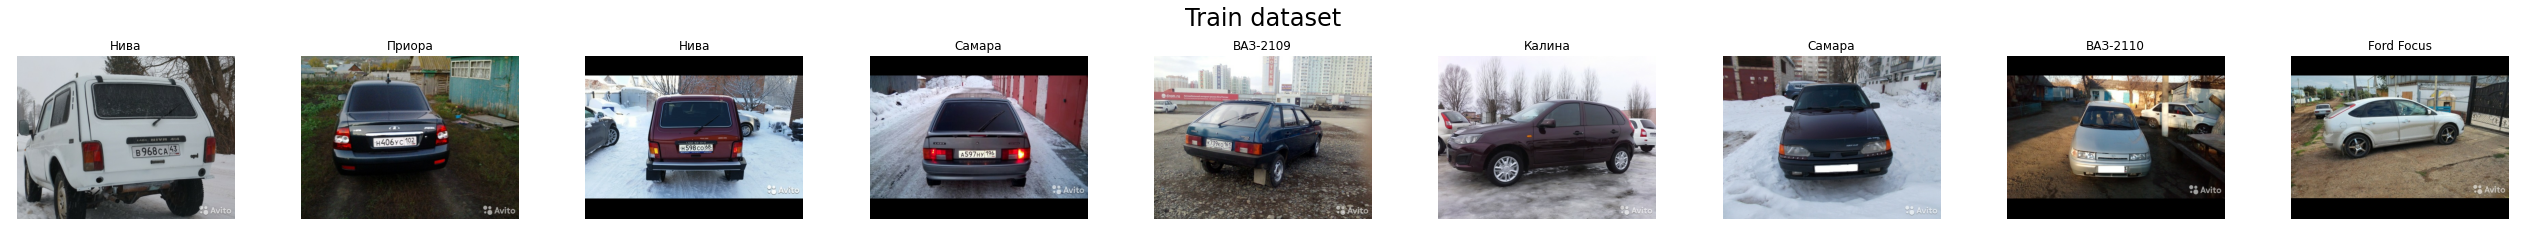

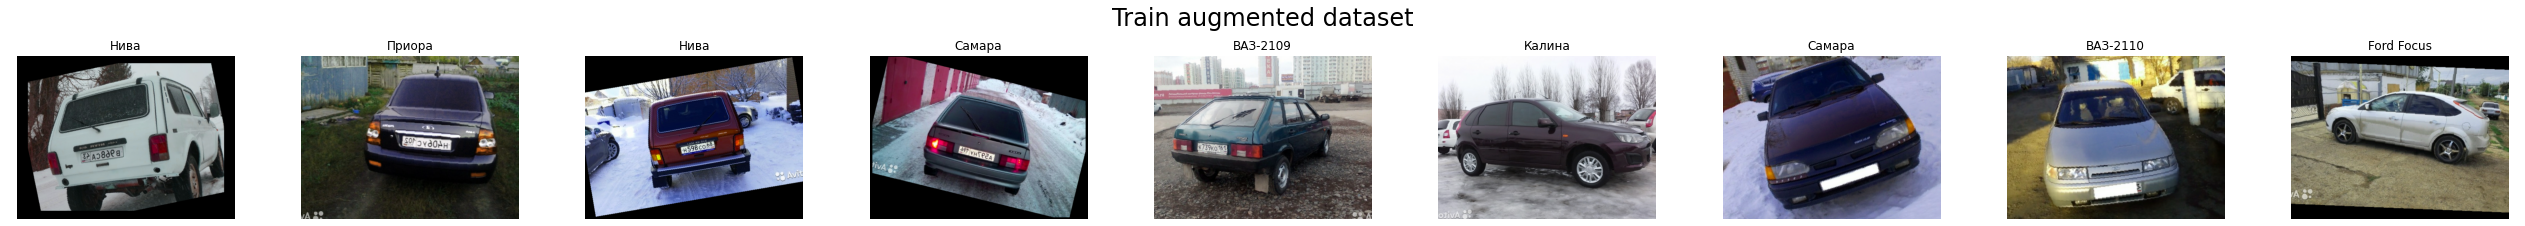

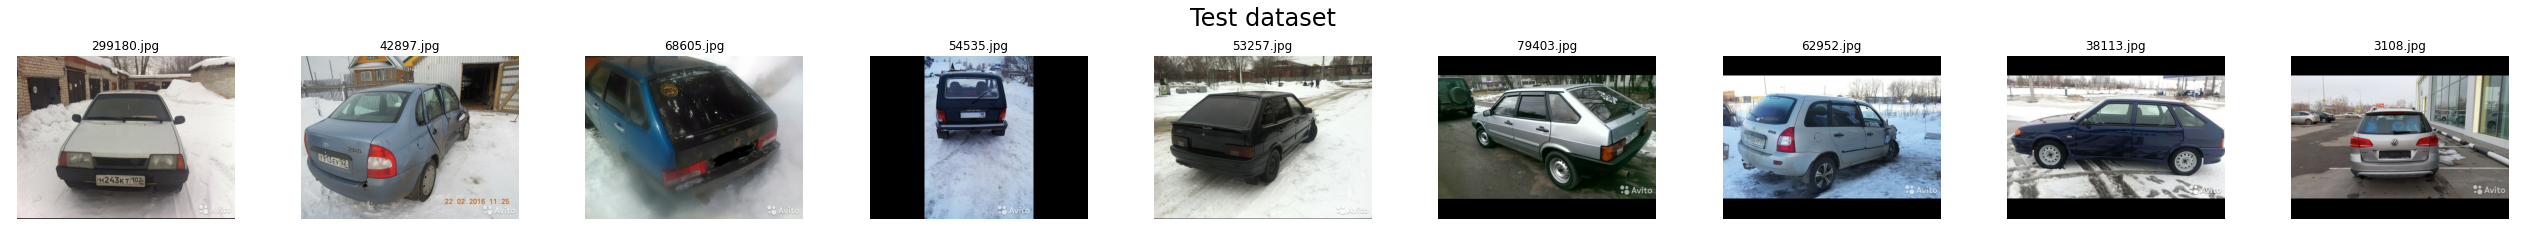

CPU times: user 4.12 s, sys: 464 ms, total: 4.58 s
Wall time: 39 s


In [ ]:
%%time

observe_train_dataset = False
observe_test_dataset = False

observe_train_dataset = True
observe_test_dataset = True

if observe_train_dataset:
  size = (480, 640)
  cols=9
  take=9
  skip=9
  raw_train_dataset = get_raw_train_dataset()
  plot_examples(
      raw_train_dataset, 
      lambda attr, i: CAT_NAMES[attr], 
      cols=cols,
      take=take, 
      skip=skip, 
      cast=lambda img: (tf.cast(pad(img, size), tf.uint8)),
      title="Train dataset")

  size = (480, 640)
  raw_train_dataset = get_raw_train_dataset()
  plot_examples(
      raw_train_dataset, 
      lambda attr, i: CAT_NAMES[attr], 
      cols=cols,
      take=take, 
      skip=skip, 
      cast=lambda img: (tf.cast(augmentation((pad(img, size))), tf.uint8)),
      # cast=lambda img: (augmentation((tf.cast(pad(img, size), tf.float32)))),
      title="Train augmented dataset")

if observe_test_dataset:
  size = (480, 640)
  cols=9
  take=9
  skip=9
  raw_test_dataset = get_raw_test_dataset()
  df_test = pd.read_csv(get_gs_df_filepath('test'))
  filenames = df_test['filename'].tolist()
  skip=len(filenames) - take
  plot_examples(
      raw_test_dataset, 
      lambda attr, i: get_filename_by_i(i, filenames, skip=skip), 
      cols=cols,
      take=take, 
      skip=skip, 
      cast=lambda img: (tf.cast(pad(img, size), tf.uint8)),
      title="Test dataset"
      )

## Обучение моделей

In [ ]:
%%time
model_names = prepare_models([
   {'code': f'{INFIX}-Xception', 'base_class': tf.keras.applications.xception.Xception},
   {'code': f'{INFIX}-IRNV2', 'base_class': tf.keras.applications.InceptionResNetV2},
   {'code': f'{INFIX}-InceptionV3', 'base_class': tf.keras.applications.InceptionV3, 'size': (299, 299)},            
], common={ 
    'augmentation': augmentation, 
    'use_augmentation_for_validation': True, 
    'batch_size': 32, 
    'size': (480, 640),
    })

Model based on 25-Xception-640x480 already exists
Model based on 25-IRNV2-640x480 already exists
Prepare model based on 25-InceptionV3-299x299 . . .
found 25-InceptionV3-299x299-step0
found 25-InceptionV3-299x299-step25
used augmentation for train
used augmentation for validation
Loading gs://yurybikuzin/car-classification/models/25-InceptionV3-299x299-step25.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/25-InceptionV3-299x299-step25.h5
Finetune model: 50% trainable
model compile . . .
model compiled
batch_size: 32, steps_per_epoch: 364, epochs: 20, min_delta: 0.0055, patience: 0
Epoch 1/20
364/364 [==============================] - 187s 515ms/step - loss: 1.0490 - accuracy: 0.6452 - val_loss: 1.0281 - val_accuracy: 0.7134
Epoch 2/20
364/364 [==============================] - 172s 473ms/step - loss: 0.6760 - accuracy: 0.7715 - val_loss: 0.3347 - val_accuracy: 0.8740
Epoch 3/20
364/364 [==============================] - 173s 475ms/step - loss: 0.5179 - accuracy: 0.8255 - va

## Проверяем результаты обучения

Run model . . .
Loading gs://yurybikuzin/car-classification/models/25-Xception-640x480.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/25-Xception-640x480.h5
Got predictions


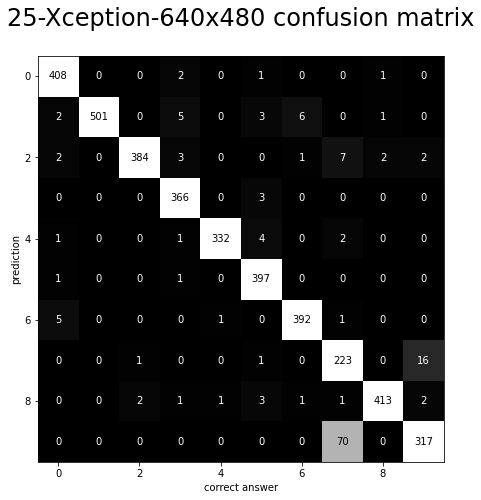

Аccuracy: 95.96%
Run model . . .
Loading gs://yurybikuzin/car-classification/models/25-IRNV2-640x480.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/25-IRNV2-640x480.h5
Got predictions


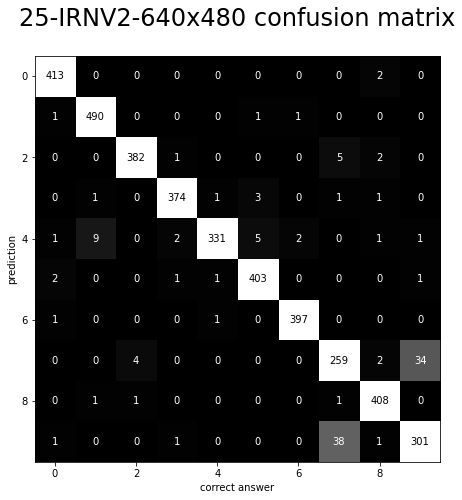

Аccuracy: 96.61%
Run model . . .
Loading gs://yurybikuzin/car-classification/models/25-InceptionV3-299x299.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/25-InceptionV3-299x299.h5
Got predictions


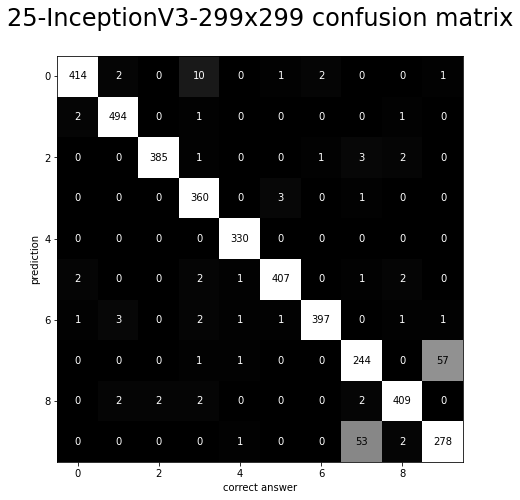

Аccuracy: 95.58%
cat_accs[25-Xception-640x480: [0.9902912621359223, 0.9671814671814671, 0.9576059850374065, 0.991869918699187, 0.9764705882352941, 0.9949874686716792, 0.9824561403508771, 0.9253112033195021, 0.9740566037735849, 0.8191214470284238]
cat_accs[25-IRNV2-640x480: [0.9951807228915662, 0.9939148073022313, 0.9794871794871794, 0.9816272965879265, 0.9403409090909091, 0.9877450980392157, 0.9949874686716792, 0.8662207357859532, 0.9927007299270073, 0.8801169590643275]
cat_accs[25-InceptionV3-299x299: [0.9627906976744186, 0.9919678714859438, 0.9821428571428571, 0.989010989010989, 1.0, 0.980722891566265, 0.9754299754299754, 0.8052805280528053, 0.9808153477218226, 0.8323353293413174]
mode max


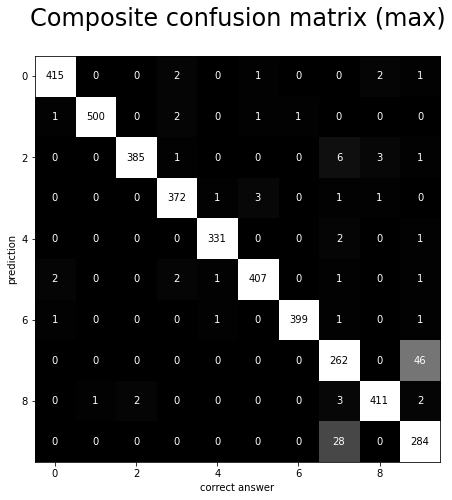

Аccuracy: 96.81%
cat_accs[25-Xception-640x480: [0.9902912621359223, 0.9671814671814671, 0.9576059850374065, 0.991869918699187, 0.9764705882352941, 0.9949874686716792, 0.9824561403508771, 0.9253112033195021, 0.9740566037735849, 0.8191214470284238]
cat_accs[25-IRNV2-640x480: [0.9951807228915662, 0.9939148073022313, 0.9794871794871794, 0.9816272965879265, 0.9403409090909091, 0.9877450980392157, 0.9949874686716792, 0.8662207357859532, 0.9927007299270073, 0.8801169590643275]
cat_accs[25-InceptionV3-299x299: [0.9627906976744186, 0.9919678714859438, 0.9821428571428571, 0.989010989010989, 1.0, 0.980722891566265, 0.9754299754299754, 0.8052805280528053, 0.9808153477218226, 0.8323353293413174]
mode sum


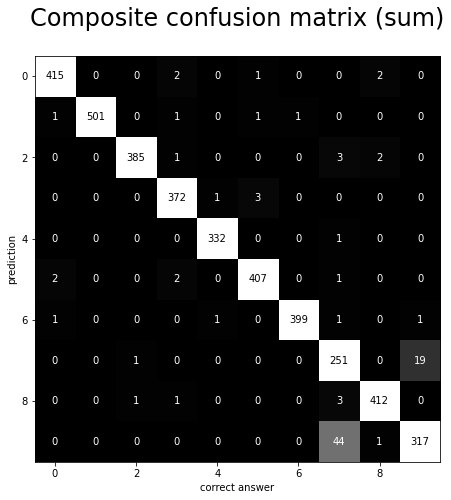

Аccuracy: 97.46%
CPU times: user 1min 34s, sys: 33.2 s, total: 2min 7s
Wall time: 11min 55s


In [ ]:
%%time
show_confusion_matrixs(model_names)

In [ ]:
%%time
submission_name = f'{INFIX}-640x480-sum-comp'
if not tf.io.gfile.exists(get_submission_filepath(submission_name)):
  df = get_composite_submission(model_names, mode='sum')
  df.drop(model_names, axis=1, inplace=True)
  save_submission(df, submission_name)

Get raw_test_dataset . . .
Run model . . .
Got predictions
Run model . . .
Got predictions
Run model . . .
Got predictions
cat_accs[25-Xception-640x480: [0.9902912621359223, 0.9671814671814671, 0.9576059850374065, 0.991869918699187, 0.9764705882352941, 0.9949874686716792, 0.9824561403508771, 0.9253112033195021, 0.9740566037735849, 0.8191214470284238]
cat_accs[25-IRNV2-640x480: [0.9951807228915662, 0.9939148073022313, 0.9794871794871794, 0.9816272965879265, 0.9403409090909091, 0.9877450980392157, 0.9949874686716792, 0.8662207357859532, 0.9927007299270073, 0.8801169590643275]
cat_accs[25-InceptionV3-299x299: [0.9627906976744186, 0.9919678714859438, 0.9821428571428571, 0.989010989010989, 1.0, 0.980722891566265, 0.9754299754299754, 0.8052805280528053, 0.9808153477218226, 0.8323353293413174]
mode sum
filenames: 6675, composite_predict: 6675
Saved gs://yurybikuzin/car-classification/submissions/subm-25-640x480-sum-comp.csv
CPU times: user 2.19 s, sys: 585 ms, total: 2.78 s
Wall time: 11min 1

## Размечаем тестовые данные и расширяем ими датасет


In [ ]:
%%time
prepare_raw_test_dataset_labeled_by_sumbission(submission_name)

gs://yurybikuzin/car-classification/submissions/subm-25-640x480-sum-comp.csv already exists
Prepare data test-25-640x480-sum-comp . . .
unzip_data test . . .
Copy gs://yurybikuzin/car-classification/data/test.zip to data/test.zip . . .
Unzip data/test.zip . . .
unzipped
prepare_df test-25-640x480-sum-comp . . .
prepare_df is done                            filepath  cat
0   unzipped/test_upload/305108.jpg    7
1   unzipped/test_upload/298803.jpg    1
2    unzipped/test_upload/57528.jpg    6
3    unzipped/test_upload/38375.jpg    9
4   unzipped/test_upload/297710.jpg    4
5    unzipped/test_upload/40023.jpg    0
6   unzipped/test_upload/295343.jpg    1
7   unzipped/test_upload/295075.jpg    6
8   unzipped/test_upload/305349.jpg    4
9    unzipped/test_upload/30823.jpg    8
10   unzipped/test_upload/63911.jpg    1
11   unzipped/test_upload/67660.jpg    2
12    unzipped/test_upload/6066.jpg    8
13   unzipped/test_upload/47858.jpg    7
14   unzipped/test_upload/31197.jpg    4
15    unzipp

## Обучаем модели на расширенном датасете

In [ ]:
%%time
model_names = prepare_models([
   {'code': f'imp-{INFIX}-Xception', 'base_class': tf.keras.applications.xception.Xception},
   {'code': f'imp-{INFIX}-IRNV2', 'base_class': tf.keras.applications.InceptionResNetV2},
   {'code': f'imp-{INFIX}-InceptionV3', 'base_class': tf.keras.applications.InceptionV3, 'size': (299, 299)},            
], common={ 
    'augmentation': augmentation, 
    'use_augmentation_for_validation': True, 
    'batch_size': 32, 
    'size': (480, 640),
    'patience': 1,
    'min_delta_from': 0.005,
    'min_delta_to': 0.0001,
    })

Prepare model based on imp-25-Xception-640x480 . . .
get_raw_train_dataset: _raw_train_dataset.concatenate(_raw_test_dataset_labeled)
used augmentation for train
used augmentation for validation
force_new_model: True, _model is None: False
base_model_class: <function Xception at 0x7f4699571488>
83689472/83683744 [==============================] - 1s 0us/step
Finetune model: 0% trainable
model compile . . .
model compiled
batch_size: 32, steps_per_epoch: 521, epochs: 20, min_delta: 0.005, patience: 0
Epoch 1/20
521/521 [==============================] - 569s 1s/step - loss: 1.6100 - accuracy: 0.4480 - val_loss: 0.9769 - val_accuracy: 0.6456
Epoch 2/20
521/521 [==============================] - 559s 1s/step - loss: 1.3248 - accuracy: 0.5375 - val_loss: 0.8741 - val_accuracy: 0.6944
Epoch 3/20
521/521 [==============================] - 557s 1s/step - loss: 1.2513 - accuracy: 0.5573 - val_loss: 0.8226 - val_accuracy: 0.7111
Epoch 4/20
521/521 [==============================] - 562s 1s/step

## Проверяем результаты обучения на расширенных данных

Run model . . .
Loading gs://yurybikuzin/car-classification/models/imp-25-Xception-640x480.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/imp-25-Xception-640x480.h5
Got predictions


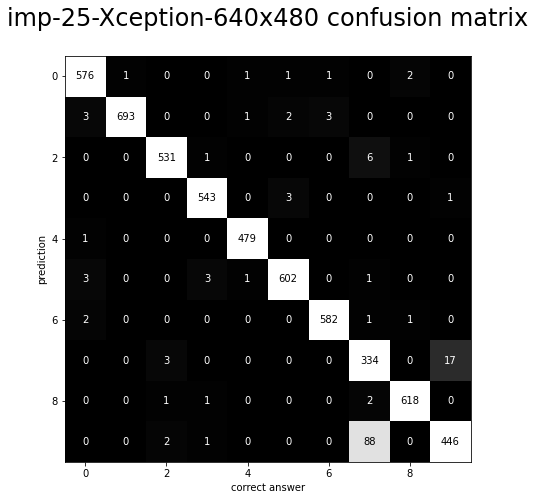

Аccuracy: 97.21%
Run model . . .
Loading gs://yurybikuzin/car-classification/models/imp-25-IRNV2-640x480.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/imp-25-IRNV2-640x480.h5
Got predictions


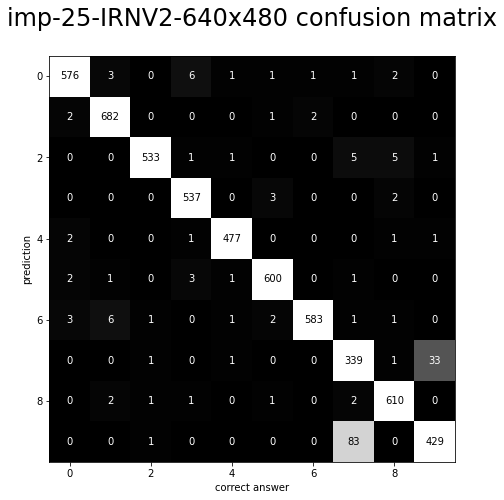

Аccuracy: 96.53%
Run model . . .
Loading gs://yurybikuzin/car-classification/models/imp-25-InceptionV3-299x299.h5 . . .
Loaded gs://yurybikuzin/car-classification/models/imp-25-InceptionV3-299x299.h5
Got predictions


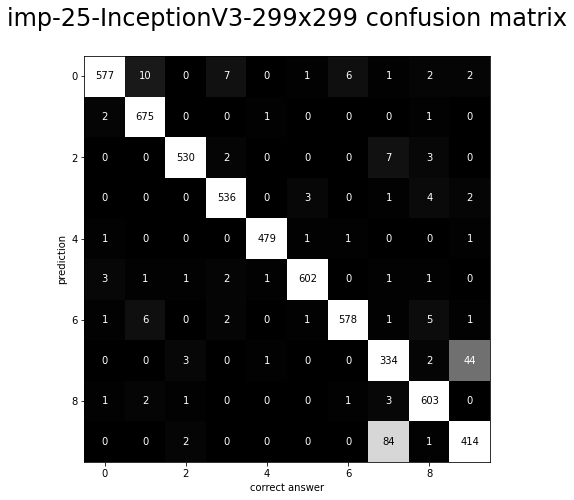

Аccuracy: 95.84%
cat_accs[imp-25-Xception-640x480: [0.9896907216494846, 0.9871794871794872, 0.9851576994434137, 0.9926873857404022, 0.9979166666666667, 0.9868852459016394, 0.9931740614334471, 0.943502824858757, 0.9935691318327974, 0.8305400372439479]
cat_accs[imp-25-IRNV2-640x480: [0.9746192893401016, 0.992721979621543, 0.9761904761904762, 0.9907749077490775, 0.9896265560165975, 0.9868421052631579, 0.9749163879598662, 0.904, 0.9886547811993517, 0.8362573099415205]
cat_accs[imp-25-InceptionV3-299x299: [0.9521452145214522, 0.9941089837997055, 0.977859778597786, 0.9816849816849816, 0.9917184265010351, 0.9836601307189542, 0.9714285714285714, 0.8697916666666666, 0.9869067103109657, 0.8263473053892215]
mode max


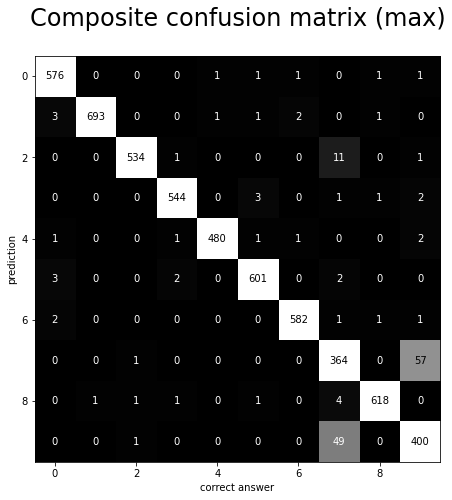

Аccuracy: 97.00%
cat_accs[imp-25-Xception-640x480: [0.9896907216494846, 0.9871794871794872, 0.9851576994434137, 0.9926873857404022, 0.9979166666666667, 0.9868852459016394, 0.9931740614334471, 0.943502824858757, 0.9935691318327974, 0.8305400372439479]
cat_accs[imp-25-IRNV2-640x480: [0.9746192893401016, 0.992721979621543, 0.9761904761904762, 0.9907749077490775, 0.9896265560165975, 0.9868421052631579, 0.9749163879598662, 0.904, 0.9886547811993517, 0.8362573099415205]
cat_accs[imp-25-InceptionV3-299x299: [0.9521452145214522, 0.9941089837997055, 0.977859778597786, 0.9816849816849816, 0.9917184265010351, 0.9836601307189542, 0.9714285714285714, 0.8697916666666666, 0.9869067103109657, 0.8263473053892215]
mode sum


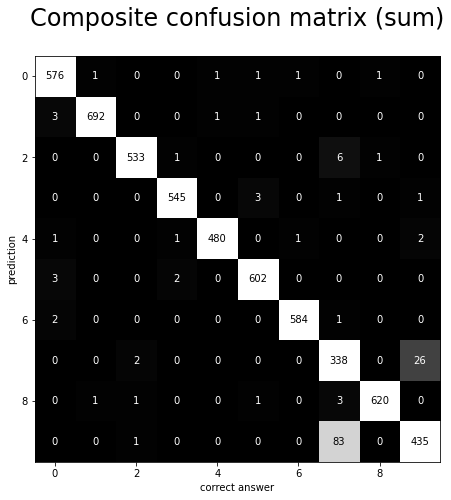

Аccuracy: 97.23%
CPU times: user 1min 57s, sys: 42.5 s, total: 2min 40s
Wall time: 17min 15s


In [ ]:
%%time
show_confusion_matrixs(model_names)

## Готовим финальные submission'ы

In [ ]:
for model_name in model_names:
  prepare_submission_of(model_name)
for mode in ['sum', 'max']:
  df = get_composite_submission(model_names, mode=mode)
  df.drop(model_names, axis=1, inplace=True)
  save_submission(df, f'{INFIX}-640x480-fin-{mode}')

Run model . . .
Got predictions
Saved gs://yurybikuzin/car-classification/submissions/subm-imp-25-Xception-640x480.csv
Run model . . .
Got predictions
Saved gs://yurybikuzin/car-classification/submissions/subm-imp-25-IRNV2-640x480.csv
Run model . . .
Got predictions
Saved gs://yurybikuzin/car-classification/submissions/subm-imp-25-InceptionV3-299x299.csv
Get raw_test_dataset . . .
cat_accs[imp-25-Xception-640x480: [0.9896907216494846, 0.9871794871794872, 0.9851576994434137, 0.9926873857404022, 0.9979166666666667, 0.9868852459016394, 0.9931740614334471, 0.943502824858757, 0.9935691318327974, 0.8305400372439479]
cat_accs[imp-25-IRNV2-640x480: [0.9746192893401016, 0.992721979621543, 0.9761904761904762, 0.9907749077490775, 0.9896265560165975, 0.9868421052631579, 0.9749163879598662, 0.904, 0.9886547811993517, 0.8362573099415205]
cat_accs[imp-25-InceptionV3-299x299: [0.9521452145214522, 0.9941089837997055, 0.977859778597786, 0.9816849816849816, 0.9917184265010351, 0.9836601307189542, 0.97142